In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import IPython.display as ipd
import numpy as np
%matplotlib notebook
from scipy.signal import lfilter

# Phasor
    sin wave같은 그림을 만들어주는 장치.

    1초에 몇 번 있느냐는 무조건 hz로 표현. sin wave가 1초동안 몇 번 왔다갔다 하는가?도 hz로 표현. unit이 달라도 hz로 표현하는 것.
    sampling rate도 hz쓰고 frequency도 hz 쓰지만 둘은 다른 개념임에 주의!
    고주파: high frequency/ 저주파: low frequency
    sin wave의 높낮이는 빠르기와 관련이 있고 진폭은 세기와 관련이 있음. 둘은 독립적.
    frequent는 cycle이 몇 번 반복되는가를 의미.

In [2]:
# parameter setting
amp = 1     # range [0.0, 1.0]
sr = 10000  # sampling rate, Hz, must be integer. 자연상의 소리는 continuous. 소리는 40000k가 넘어가면 인간이 구분하기 어렵다.
# 0~20000K가 인간의 가청주파수.
dur = 0.5   # in seconds, may be float
freq = 100.0        # sine frequency, Hz, may be float


In [3]:
# generate time --> x축을 시간으로 만들어야 sound를 뽑아내는 의미있음.
t = np.arange(1, sr * dur+1)/sr 
# dur+1은 4999까지 뱉어내니까 5000까지 계산하라는 의미. 시간을 1/10000초부터 5000/10000초까지 만든 것.
# dur이 1일 때 0부터 1초까지는 10000개의 숫자 정보가 들어가 있음. sampling rate의 개념과 동일
# 1초안에 총 10000개의 time을 만들어주는 것.
len(t)

5000

In [4]:
# generate phase
theta = t * 2*np.pi * freq
# freq가 정해지면 time을 radian 값으로 바꿀 수 있음.
# 0부터 1까지가 0부터 2파이로 바뀜. 

In [5]:
# generate signal by cosine-phasor
s = np.sin(theta)
# sin에는 개념적으로 '각도'가 들어올 것을 기대. 반드시 radian의 형태로 넣어야 의미있음. (1/2, 루트2/2 등)

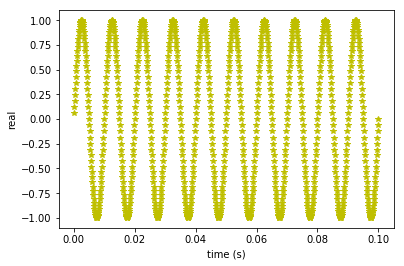

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s[0:1000], 'y*')
# 마지막 element는 없어도 됨. plot을 하는데는 theta가 쓰이지 않음. 
ax.set_xlabel('time (s)')
ax.set_ylabel('real')
# y축은 sin이 뱉어내는 값. 점의 개수는 s, t, theta의 개수와 동일
ipd.Audio(s, rate=sr)

In [7]:
# generate signal by exponential-phasor
c = np.exp(theta*1j)

Text(0.5, 0, 'imag')

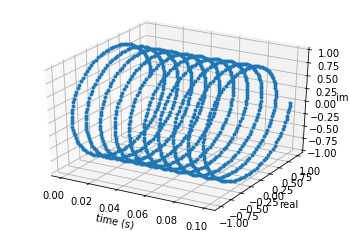

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(t[0:1000], c.real[0:1000], c.imag[0:1000], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('real')
ax.set_zlabel('imag')

In [9]:
ipd.Audio(s, rate=sr)

# Generate pulse train

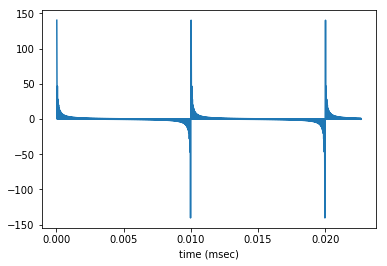

In [11]:
# generate samples, note conversion to float32 array
F0 = 100; Fend = int(sr/2); s = np.zeros(len(t));
for freq in range(F0, Fend, F0):
    theta = t * 2*np.pi * freq
    tmp = amp * np.sin(theta)
    s = s + tmp
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s, rate=sr)

# load wav

In [24]:
from scipy.io import wavfile
sr, s = wavfile.read('a.wav')
nSamp = len(s)
dur = nSamp / sr
t = np.linspace(1/sr, dur, nSamp)

# fourier tranform

In [25]:
nFFT = 512
amp = [];
for n in range(1,nFFT+1):
    theta = 2*np.pi*n/nFFT * np.arange(1,nSamp+1)
    c = np.exp(theta*1j)
    amp.append(np.abs(np.dot(s,c)))

Text(0, 0.5, 'amplitude')

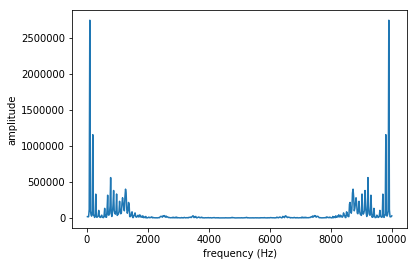

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
freq = np.arange(1,nFFT+1)*sr/nFFT;
ax.plot(freq, amp)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('amplitude')

# define spectrogram functions

In [ ]:
def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax

def praat_spectrogram(x, fs, window_dur=0.005, dyn_range=120, ax=None):
    # this function is less flexible than the other (to make it shorter, 
    # since it's just for demo purposes).
    from scipy.signal import spectrogram, gaussian
    from matplotlib.cm import get_cmap
    
    step_dur = window_dur / np.sqrt(np.pi) / 8.
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    noverlap = window_nsamp - step_nsamp
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)
    p_ref = 2e-5
    log_psd = 10 * np.log10(power / (p_ref ** 2))  # key difference
    dB_max = log_psd.max()
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)
    cmap = get_cmap('Greys')
    if ax is None:
        fig, ax = plt.subplots()
    extent = (times.min(), times.max(), freqs.min(), freqs.max())
    # next line: pass `log_psd` instead of `power`; no `LogNorm`
    ax.imshow(log_psd, origin='lower', aspect='auto', cmap=cmap,
              extent=extent, vmin=vmin, vmax=None)
    return ax

# display spectrogram

Text(0.5, 1.0, 'Log power spectral density & linear colormap')

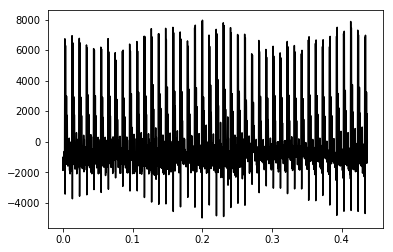

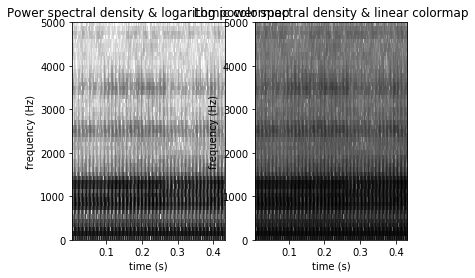

In [6]:
plt.plot(t,s, 'k')

fig, axs = plt.subplots(1, 2)
ax = gaussian_spectrogram(s, sr, ax=axs[0])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Power spectral density & logarithmic colormap')

ax = praat_spectrogram(s, sr, ax=axs[1])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Log power spectral density & linear colormap')